## Double Deep Q-Network
A criticism of the deep q-network (DQN) introduced previously is that it overestimates the values of actions. In DQN, the target is computed as:

$$Y_t^{DQN} \equiv R_{t+1} + \gamma max_a Q(S_{t+1}, a; \theta_t^-)$$

Hado et al argue that the estimation is due to the max operator which is used to both select and evaluate an action. When using tabular methods with Q-learning, the same overestimation is noticed as well. To solve the problem, Double Q-learning (DQL) was introduced. In [1], the DQN was adapted to use DQL and the resulting technique was termed Double Deep Q-Network (DDQN). In DDQN, the targets are computed as follows:

$$Y_t^{DDQN} \equiv R_{t+1} + \gamma Q(S_{t+1}, argmax_a Q(S_{t+1}, a; \theta_t); \theta_t^-)$$

Several things have happend here. Firstly, the **online network is used to select an action** in the next state $S_{t+1}$. Secondly, the **target network is used to compute the value** of taking the selected action in that state. Take a moment to study both equations to convince yourself of the changes.

A final point is that overoptimism is not always a bad thing as the DQN was still able to achieve state of the art results. The use of a DDQN also does not guarantee better results. However, reducing overoptimism can benefit the stability of learning. Below I compare the performance of DQN vs DDQN. The changes are slight and are concentrated in the train() method. Everything else is left unchanged.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *
%matplotlib inline

In [2]:
class ReplayBuffer: 
    """
    Fixed capacity buffer implemented as circular queue
    Transitions are stored as (s, a, r, s', done) tuples
    """
    def __init__(self, capacity):
        self.samples = np.ndarray(capacity, dtype=object)
        self.capacity = capacity
        self.counter = 0
        self.flag = False
        
    def size(self):
        if self.flag:
            return self.capacity
        else:
            return self.counter
        
    def add(self, sample):
        self.samples[self.counter] = sample
        
        self.counter += 1
        if self.counter >= self.capacity:
            self.counter = 0
            self.flag = True
            
    def sample(self, n):
        n = min(n, self.size())
        
        size = self.size()
        if size < self.capacity:
            return np.random.choice(self.samples[:size], n, replace=False)
        else:
            return np.random.choice(self.samples, n, replace=False)

In [3]:
class Agent:
    def __init__(self, state_dim, action_dim, learning_rate):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.epsilon = 1
        
        # Create the model and set up trainer
        self.state_var = input(self.state_dim, np.float32)
        self.action_var = input(self.action_dim, np.float32)
        
        self.online_model = Sequential([
            Dense(64, activation=relu),
            Dense(self.action_dim)
        ])(self.state_var)

        loss = reduce_mean(square(self.online_model - self.action_var), axis=0)
        lr_schedule = learning_rate_schedule(self.learning_rate, UnitType.sample)
        learner = sgd(self.online_model.parameters, lr_schedule)
        self.trainer = Trainer(self.online_model, loss, learner)
        
        # Create target network and initialize with same weights
        self.target_model = None
        self.update_target()
    
    def update_target(self):
        """
        Updates the target network using the online network weights
        """
        self.target_model = self.online_model.clone(CloneMethod.clone)
        
    def update_epsilon(self, episode):
        """
        Updates epsilon using exponential decay with the decay rate chosen such
        that epsilon is 0.05 by episode 8000
        """
        self.epsilon = max(math.exp(-3.74e-4 * episode), 0.05)
        
    def predict(self, s, target=False):
        """
        Feeds a state through the model (our network) and obtains the values of each action
        """
        if target:
            return self.target_model.eval(s)
        else:
            return self.online_model.eval(s)
        
    def act(self, state):
        """
        Selects an action using the epoch-greedy approach
        """
        prob = np.random.randn(1)
        if prob > self.epsilon:
            # exploit (greedy)
            return np.argmax(self.predict(state))
        else:
            # explore (random action)
            return np.random.randint(0, self.action_dim)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step using the provided states and targets
        """
        self.trainer.train_minibatch({self.state_var: x, self.action_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the trained model over n episodes
        """
        episode = 0
        rewards = 0
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
            
        return rewards / float(n)

In [4]:
def initialize_buffer(env, buffer):
    """
    Initializes the replay buffer using experiences generated by taking random actions
    """
    actions = env.action_space.n
    s = env.reset()
    
    while buffer.size() < buffer.capacity:
        a = np.random.randint(0, actions)
        s_, r, done, info = env.step(a)
        
        buffer.add((s, a, r, s_, done))
        
        if done:
            s = env.reset()
        else:
            s = s_

Notice the change in how we compute the targets for DDQN here. We use the online network to get the values of actions in the next state and then select the one with the highest value. We then use the target network to compute the value of selecting that action. Slight change, but large difference.

In [5]:
def train(env, agent, buffer, episodes, gamma, minibatch_size, update_freq, ddqn=False):
    """
    param env: The gym environment to train with
    param agent: The agent to train
    param buffer: The replay buffer to sample experiences from
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    param minibatch_size: The number of transitions to sample for 
    param update_freq: The frequency at which to update the target network
    param ddqn: If true, uses DDQN expression to compute targets
    """
    episode = 0
    rewards = 0
    log_freq = 200
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select an action using policy derived from Q (e-greedy)
        a = agent.act(s)
        
        # Take action and observe the next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)
        
        # Store transition in replay buffer
        buffer.add((s, a, r, s_, done))
        
        s = s_
        rewards += r
        
        # Sample random transitions from replay buffer
        batch = buffer.sample(minibatch_size)
        
        # Compute targets, y_i
        states = np.array([obs[0] for obs in batch], dtype=np.float32)
        states_ = np.array([obs[3] for obs in batch], dtype=np.float32)
        y = agent.predict(states)
        
        if not ddqn:
            q_next = agent.predict(states_, target=True)
            for i in range(minibatch_size):
                p, a, r, p_, d = batch[i]
                if d:
                    y[i, a] = r
                else:
                    y[i, a] = r + gamma * np.amax(q_next[i])
                    
        else:
            q_next = agent.predict(states_)
            q_next_target = agent.predict(states_, target=True)
            for i in range(minibatch_size):
                p, a, r, p_, d = batch[i]
                if d:
                    y[i, a] = r
                else:
                    y[i, a] = r + gamma * q_next_target[i][np.argmax(q_next[i])]
        
        # Train using state and computed target
        agent.train(states, y)
        
        if done:
            # Episode over, reset environment
            episode_rewards.append(rewards)
            rewards = 0
            
            episode += 1
            agent.update_epsilon(episode)
            s = env.reset().astype(np.float32)
            
            if episode % log_freq == 0:
                ave = sum(episode_rewards[(episode - log_freq):]) / float(log_freq)
                print('Episode = {}, Average rewards = {}'.format(episode, ave))
                
            if episode % update_freq == 0:
                agent.update_target()                
                
    return episode_rewards

In [6]:
gamma = 0.60
learning_rate = 0.00025
episodes = 10000
buffer_capacity = 32
minibatch_size = 8
update_freq = 500

In [7]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape
action_dim = env.action_space.n

[2017-04-23 11:54:17,296] Making new env: CartPole-v0


In [8]:
buffer1 = ReplayBuffer(buffer_capacity)
agent1 = Agent(state_dim, action_dim, learning_rate)

In [9]:
buffer2 = ReplayBuffer(buffer_capacity)
agent2 = Agent(state_dim, action_dim, learning_rate)

In [10]:
initialize_buffer(env, buffer1)
rewards1 = train(env, agent1, buffer1, episodes, gamma, minibatch_size, update_freq)

Episode = 200, Average rewards = 17.89
Episode = 400, Average rewards = 17.14
Episode = 600, Average rewards = 18.205
Episode = 800, Average rewards = 19.03
Episode = 1000, Average rewards = 17.87
Episode = 1200, Average rewards = 23.405
Episode = 1400, Average rewards = 24.35
Episode = 1600, Average rewards = 25.45
Episode = 1800, Average rewards = 32.29
Episode = 2000, Average rewards = 30.555
Episode = 2200, Average rewards = 34.87
Episode = 2400, Average rewards = 36.205
Episode = 2600, Average rewards = 39.715
Episode = 2800, Average rewards = 37.735
Episode = 3000, Average rewards = 44.33
Episode = 3200, Average rewards = 47.62
Episode = 3400, Average rewards = 51.415
Episode = 3600, Average rewards = 56.025
Episode = 3800, Average rewards = 55.185
Episode = 4000, Average rewards = 53.395
Episode = 4200, Average rewards = 62.545
Episode = 4400, Average rewards = 62.775
Episode = 4600, Average rewards = 68.05
Episode = 4800, Average rewards = 67.97
Episode = 5000, Average rewards 

In [11]:
initialize_buffer(env, buffer2)
rewards2 = train(env, agent2, buffer2, episodes, gamma, minibatch_size, update_freq, ddqn=True)

Episode = 200, Average rewards = 20.03
Episode = 400, Average rewards = 18.565
Episode = 600, Average rewards = 17.72
Episode = 800, Average rewards = 19.625
Episode = 1000, Average rewards = 18.225
Episode = 1200, Average rewards = 24.015
Episode = 1400, Average rewards = 31.67
Episode = 1600, Average rewards = 29.32
Episode = 1800, Average rewards = 33.205
Episode = 2000, Average rewards = 36.25
Episode = 2200, Average rewards = 39.855
Episode = 2400, Average rewards = 38.96
Episode = 2600, Average rewards = 42.665
Episode = 2800, Average rewards = 42.195
Episode = 3000, Average rewards = 52.355
Episode = 3200, Average rewards = 50.505
Episode = 3400, Average rewards = 53.42
Episode = 3600, Average rewards = 51.44
Episode = 3800, Average rewards = 51.325
Episode = 4000, Average rewards = 59.91
Episode = 4200, Average rewards = 68.185
Episode = 4400, Average rewards = 72.89
Episode = 4600, Average rewards = 71.605
Episode = 4800, Average rewards = 67.885
Episode = 5000, Average reward

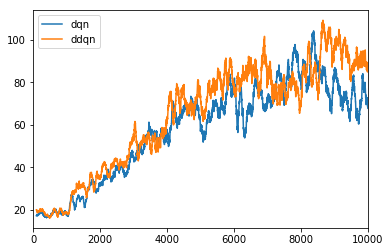

In [12]:
pd.Series(rewards1).rolling(window=100).mean().plot(label='dqn')
pd.Series(rewards2).rolling(window=100).mean().plot(label='ddqn')
plt.legend()
plt.show()

In [17]:
eval_episodes = 200
ave1 = agent1.evaluate(env, eval_episodes)
ave2 = agent2.evaluate(env, eval_episodes)

print('DQN Average performance = {}'.format(ave1))
print('DDQN Average performance = {}'.format(ave2))

DQN Average performance = 196.9
DDQN Average performance = 180.35


The chart above and the results for average performance assert the fact that the use of a DDQN doesn't always improve performance. You may notice though that for a majority of the chart, the average reward for DDQN was higher than that of DQN. CartPole is a relatively simple problem though and the benefits of a DDQN will most likely be more apparent when used with more complex problems. To have a more assertive conclusion, we could run the experiment several times and average of the results of both.

Once again, you can try out your own experiments by modifying the different parameters and noting the performance of both algorithms.

In [14]:
agent2.online_model.save_model('cart_pole.ddqn')

In [15]:
# Load saved model and evaluate
model = load_model('cart_pole.ddqn')

s = env.reset()
done = False
while not done:
    env.render()
    a = np.argmax(model.eval(s.astype(np.float32)))
    s, r, done, info = env.step(a)

In [16]:
env.close()

### References
[1]. Hado van Hasselt, Arthur Guez & David Silver. Deep Reinforcement Learning with Double Q-learning. arXiv:1509.06461v3